In [52]:
import geopandas as gpd
import numpy as np

import pygmo as pg

from scipy import optimize

from spineq.data_fetcher import (
    lad20nm_to_lad20cd,
    get_oa_centroids,
    get_oa_stats,
    get_oa_shapes,
)
from spineq.utils import coverage_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx

%matplotlib inline

In [2]:
lad20nm = "Gateshead"
lad20cd = lad20nm_to_lad20cd(lad20nm)

n_sensors = 20

/Users/jroberts/opt/anaconda3/envs/spatial-inequality/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Load Data

Processed in population_data.ipynb notebook.

In [23]:
oa_shapes = get_oa_shapes(lad20cd)
oa_centroids = get_oa_centroids(lad20cd)
oa_stats = get_oa_stats(lad20cd)
oa_population = oa_stats["population_ages"].sum(axis=1)
oa_population.name = "population"
oa = oa_shapes.join(oa_centroids).join(oa_population)
oa

,geometry,x,y,population
oa11cd,,,,
E00041363,"POLYGON ((425973.374 561989.125, 425877.956 56...",425983.378,562148.554,212
E00041364,"POLYGON ((425418.730 562134.331, 425358.711 56...",425443.912,562250.409,536
E00041366,"POLYGON ((426540.000 562393.000, 426590.000 56...",426561.905,562275.307,224
E00041367,"POLYGON ((426311.000 562385.221, 426309.862 56...",426183.089,562133.054,199
E00041368,"POLYGON ((426362.980 561918.501, 426352.333 56...",426497.293,561986.765,283
...,...,...,...,...
E00170024,"POLYGON ((429641.069 561873.808, 429718.935 56...",429777.910,561835.726,337
E00170026,"POLYGON ((420439.000 562189.000, 420343.017 56...",420023.542,562265.974,339
E00170027,"POLYGON ((419475.916 561873.418, 419581.300 56...",420176.887,561867.015,216


In [24]:
print(oa.x.min(), oa.x.max())
print(oa.y.min(), oa.y.max())

411466.693 430727.665
554041.284 565036.265


In [25]:
populations = oa["population"]

## Calculate Distances Between Output Areas

In [26]:
centroids = np.array([oa["x"], oa["y"]]).T
centroids.shape

(706, 2)

In [27]:
dist_sq = np.sum(
    (centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2, axis=-1
)

distances = np.sqrt(dist_sq)

Max distance of 19583.80463781831 m is between E00041481 and E00042023


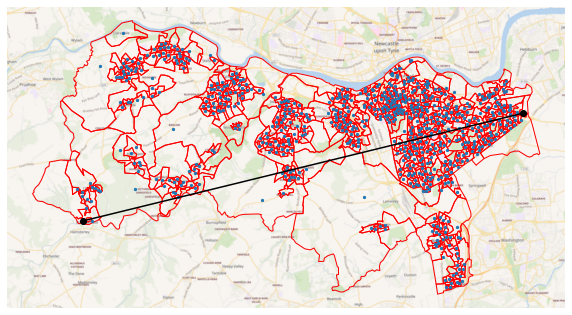

In [34]:
max_idx = np.where(distances == distances.max())[0]
print(
    "Max distance of",
    distances.max(),
    "m is between",
    oa.iloc[max_idx[0]].name,
    "and",
    oa.iloc[max_idx[1]].name,
)

ax = oa.plot(figsize=(10, 10), facecolor="none", edgecolor="red")
ctx.add_basemap(
    ax, source="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png", crs=oa.crs
)

x = oa["x"]
y = oa["y"]
ax.scatter(x, y, s=5)

x = oa.iloc[max_idx]["x"]
y = oa.iloc[max_idx]["y"]
ax.plot(x, y, "k-o")

ax.set_axis_off()

## Calculate "coverage"

coverage at any output area due to a sensor placed in any other output area.

In [37]:
def distance_to_coverage(distance, theta=1):
    return np.exp(-distance / theta)

Text(0, 0.5, 'coverage')

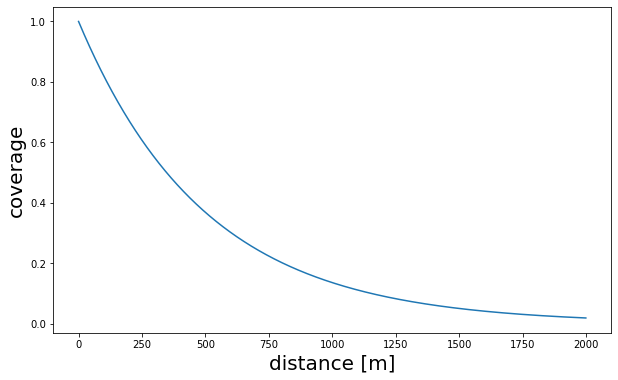

In [39]:
theta = 500

d = np.arange(0, 2000)
plt.figure(figsize=(10, 6))
plt.plot(d, distance_to_coverage(d, theta=theta))
plt.xlabel("distance [m]", fontsize=20)
plt.ylabel("coverage", fontsize=20)

In [40]:
# "coverage" at each output area due to a sensor at any other output area
coverage = distance_to_coverage(distances, theta=theta)

Text(0.5, 1.0, 'coverage due to sensor at E00041363')

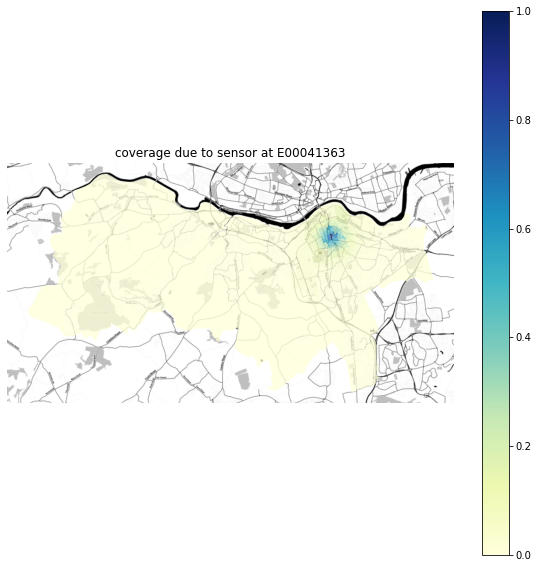

In [47]:
# coverage due to sensor at this output area index
sensor_idx = 0

oa["coverage"] = coverage[sensor_idx]

ax = oa.plot(
    column="coverage", figsize=(10, 10), alpha=0.75, cmap="YlGnBu", legend=True
)

ctx.add_basemap(ax, source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png", crs=oa.crs)

ax.set_axis_off()
plt.title("coverage due to sensor at " + oa.iloc[sensor_idx].name)

## scipy optimize

In [66]:
def objective(sensors):
    sensors_x = sensors[0::2]
    sensors_y = sensors[1::2]

    # coverage at each output area due to each sensor
    coverage = coverage_matrix(sensors_x, sensors_y, oa.x, oa.y, theta=theta)

    # coverage at each output area = coverage due to nearest sensor
    max_cov = np.max(coverage, axis=0)

    # Total population-weighted coverage of solution = our objective
    fitness = -(oa.population * max_cov).sum() / oa.population.sum()
    return fitness

In [110]:
def plot_sensors(sensors, figsize=(20, 20)):
    ax = plt.figure(figsize=figsize).gca()
    ax = oa.plot(alpha=0.25, legend=True, ax=ax, edgecolor="w")

    x = sensors[0::2]
    y = sensors[1::2]
    ax.scatter(x, y, s=50, color="r")

    ctx.add_basemap(
        ax, source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png", crs=oa.crs
    )

    ax.set_axis_off()

In [111]:
x_range = [oa.x.min(), oa.x.max()]
print(x_range)
y_range = [oa.y.min(), oa.y.max()]
print(y_range)

x_mid = np.mean(x_range)
y_mid = np.mean(y_range)

init_sensors = [x_mid if x % 2 == 0 else y_mid for x in range(2 * n_sensors)]

sensor_bounds = [x_range if x % 2 == 0 else y_range for x in range(2 * n_sensors)]

[411466.693, 430727.665]
[554041.284, 565036.265]


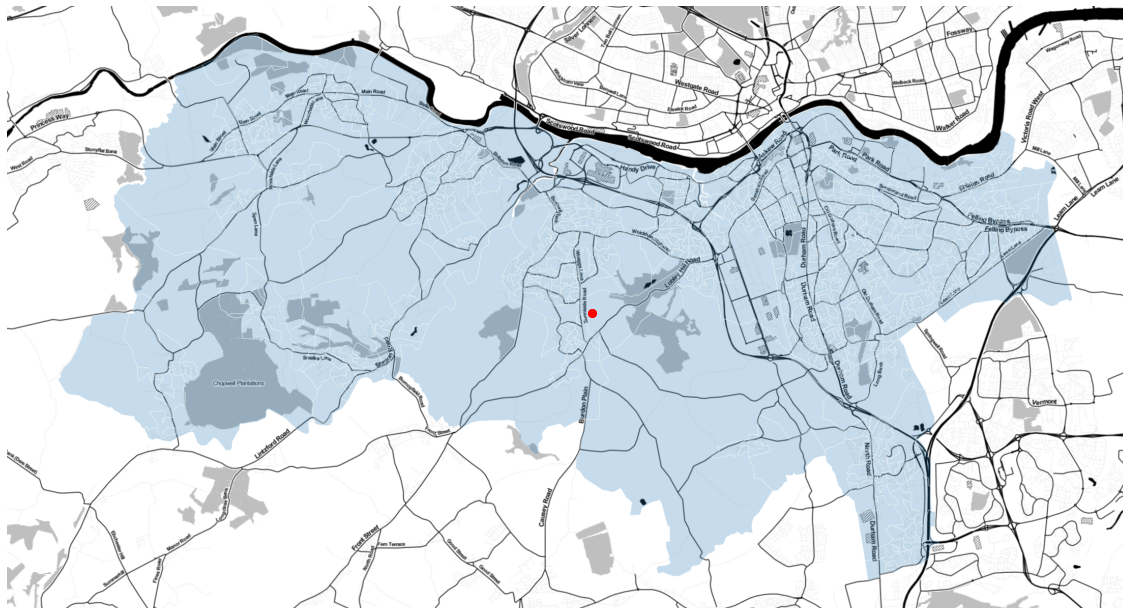

In [112]:
# init sensors to mid-points
points = optimize.minimize(objective, init_sensors)

points
plot_sensors(points.x)

In [115]:
# SLOW!
maxiter = 200


def cback(xk, convergence=0):
    print("Convergence:", round(convergence * 100, 2), "%")
    print("Current solution:", xk)
    print("-" * 20)


import time

t = time.time()
points = optimize.differential_evolution(
    objective, sensor_bounds, maxiter=maxiter, callback=cback
)
print("Took", time.time() - t, "seconds")
points

Convergence: 5.32 %
Current solution: [426254.87680722 558886.64582352 422949.46279055 554875.97934574
 425283.15031328 562128.8660917  427439.43688114 561298.95128721
 411664.9253424  556193.53649071 420978.60435274 561638.18318769
 416889.30390717 559114.31167095 417039.92282458 557847.43443653
 417781.23053855 564460.71270133 425497.89347811 561404.56634483
 429392.68391427 559875.31639904 420771.8199654  560316.95088876
 416267.60908211 564733.39526087 423440.22871537 557752.2177266
 412412.14121966 557558.27980682 429288.04562323 558153.35928461
 421996.78031684 565029.4674368  427294.83877808 556516.89717281
 425465.28950845 557772.19063161 416713.70402821 556291.75385789]
--------------------
Convergence: 6.42 %
Current solution: [428135.31781485 560288.66119799 426145.98345084 560921.27477645
 429565.38652033 562047.03617014 426644.42736139 556734.43865248
 428826.1851344  556706.28768388 425337.20123482 559117.49540134
 416174.04150091 561115.43861867 415486.97738962 558388.72

Convergence: 11.89 %
Current solution: [419759.08871339 561283.08739101 426790.55818003 561640.14137039
 422085.56983078 561714.64814557 423359.033956   561649.15155096
 414982.76948462 560864.92308495 416865.41535614 559127.42612292
 414877.24845773 563890.32410062 415838.9466224  563172.08617445
 429474.31510454 556897.77651869 426306.67007972 560119.77382888
 418741.84574675 561530.50281265 415018.39830724 564494.86809208
 424703.67193861 562177.42331282 427415.97645986 558398.5306883
 425304.43415803 558717.37111882 428198.89545304 560332.67926453
 428215.5480794  561223.94245329 429235.22318282 560205.40896777
 426233.01053096 558934.21191823 425834.93203783 561840.53437397]
--------------------
Convergence: 12.18 %
Current solution: [419759.08871339 561283.08739101 426790.55818003 561640.14137039
 422085.56983078 561714.64814557 423359.033956   561649.15155096
 414982.76948462 560864.92308495 416865.41535614 559127.42612292
 414877.24845773 563890.32410062 415838.9466224  563172.

Convergence: 15.39 %
Current solution: [423317.22443018 557853.84439319 422958.8743375  561135.58870889
 413685.22223297 562261.22574947 424921.43862572 562086.48933133
 412758.57009716 557854.33124989 413011.29951408 563597.53206313
 414536.63216047 562441.13804252 414966.29106919 562587.74292867
 425290.68374055 556952.94197538 417928.44730173 562542.64123206
 415795.63971638 558948.41341376 416036.48444913 564262.12126854
 425987.04304488 561702.66055341 428782.57230851 560686.91837756
 427221.31851502 561017.25514626 426717.01155129 558854.92233029
 426202.4229444  559406.26583227 417683.16144324 562825.76420767
 425194.67305405 562498.6856503  422538.74998274 559697.59276292]
--------------------
Convergence: 15.48 %
Current solution: [423317.22443018 557853.84439319 422958.8743375  561135.58870889
 413685.22223297 562261.22574947 424921.43862572 562086.48933133
 412758.57009716 557854.33124989 413011.29951408 563597.53206313
 414536.63216047 562441.13804252 414966.29106919 562587

Convergence: 17.03 %
Current solution: [423317.22443018 557853.84439319 422958.8743375  561135.58870889
 413685.22223297 562261.22574947 424921.43862572 562086.48933133
 412758.57009716 557854.33124989 413011.29951408 563597.53206313
 414536.63216047 562441.13804252 414966.29106919 562587.74292867
 425290.68374055 556952.94197538 417928.44730173 562542.64123206
 415795.63971638 558948.41341376 416036.48444913 564262.12126854
 425987.04304488 561702.66055341 428782.57230851 560686.91837756
 427221.31851502 561017.25514626 426717.01155129 558854.92233029
 426202.4229444  559406.26583227 417683.16144324 562825.76420767
 425194.67305405 562498.6856503  422538.74998274 559697.59276292]
--------------------
Convergence: 17.08 %
Current solution: [423932.20754445 560666.42520704 424512.23250109 561634.32756456
 417686.48638544 564049.27305978 426151.74187823 562239.20383548
 423319.08583511 561273.45526897 414396.2667553  564634.64591518
 415901.07785062 563536.97521481 418711.62530669 563027

Convergence: 18.71 %
Current solution: [428016.93118798 563778.39620318 425217.35573659 562148.00683231
 426195.1789493  561099.02209474 426481.07528974 563915.28697325
 416877.55852537 559034.9596538  417359.62027235 562511.60458856
 422891.94733352 561734.18574252 416080.57389841 564185.01850785
 427878.55244917 555691.82336999 426142.57565043 560258.16935767
 413418.42296197 563806.62177849 415116.02004822 561579.19972288
 418259.37397637 562940.7643589  424061.92119907 560742.11146516
 427441.21976571 558803.74712476 425389.32005443 556574.16458715
 426569.11689253 562002.35020012 426193.45236515 559002.89822261
 427681.88823098 562991.25712596 420907.06495575 561659.11049152]
--------------------
Convergence: 18.63 %
Current solution: [428016.93118798 563778.39620318 425217.35573659 562148.00683231
 426195.1789493  561099.02209474 426481.07528974 563915.28697325
 416877.55852537 559034.9596538  417359.62027235 562511.60458856
 422891.94733352 561734.18574252 416080.57389841 564185

Convergence: 19.63 %
Current solution: [428016.93118798 563778.39620318 425217.35573659 562148.00683231
 426195.1789493  561099.02209474 426481.07528974 563915.28697325
 416877.55852537 559034.9596538  417359.62027235 562511.60458856
 422891.94733352 561734.18574252 416080.57389841 564185.01850785
 427878.55244917 555691.82336999 426142.57565043 560258.16935767
 413418.42296197 563806.62177849 415116.02004822 561579.19972288
 418259.37397637 562940.7643589  424061.92119907 560742.11146516
 427441.21976571 558803.74712476 425389.32005443 556574.16458715
 426569.11689253 562002.35020012 426193.45236515 559002.89822261
 427681.88823098 562991.25712596 420907.06495575 561659.11049152]
--------------------
Convergence: 19.6 %
Current solution: [428016.93118798 563778.39620318 425217.35573659 562148.00683231
 426195.1789493  561099.02209474 426481.07528974 563915.28697325
 416877.55852537 559034.9596538  417359.62027235 562511.60458856
 422891.94733352 561734.18574252 416080.57389841 564185.

Convergence: 20.21 %
Current solution: [428016.93118798 563778.39620318 425217.35573659 562148.00683231
 426195.1789493  561099.02209474 426481.07528974 563915.28697325
 416877.55852537 559034.9596538  417359.62027235 562511.60458856
 422891.94733352 561734.18574252 416080.57389841 564185.01850785
 427878.55244917 555691.82336999 426142.57565043 560258.16935767
 413418.42296197 563806.62177849 415116.02004822 561579.19972288
 418259.37397637 562940.7643589  424061.92119907 560742.11146516
 427441.21976571 558803.74712476 425389.32005443 556574.16458715
 426569.11689253 562002.35020012 426193.45236515 559002.89822261
 427681.88823098 562991.25712596 420907.06495575 561659.11049152]
--------------------
Convergence: 20.31 %
Current solution: [428016.93118798 563778.39620318 425217.35573659 562148.00683231
 426195.1789493  561099.02209474 426481.07528974 563915.28697325
 416877.55852537 559034.9596538  417359.62027235 562511.60458856
 422891.94733352 561734.18574252 416080.57389841 564185

Convergence: 20.69 %
Current solution: [426167.44394801 557484.66117853 424998.44735763 563947.61443281
 429729.94050026 561383.63304089 422757.87377786 561232.55885493
 414136.5365436  555903.65451128 424762.17481502 562133.71247981
 422620.50428592 561732.56218019 418317.50458015 562925.11734118
 426880.50637478 561405.33727998 422810.39608015 562768.88355294
 417183.63131789 561843.96878735 426561.90196976 560860.00739445
 413358.32242401 563291.74409667 428367.84148948 560155.02498167
 426856.2576766  557545.95737319 427222.69455341 556275.9345907
 425329.08006842 562355.5389757  425416.16059687 559869.1438825
 430575.75741357 562760.75720917 416145.12645918 564042.80875253]
--------------------
Convergence: 20.73 %
Current solution: [426167.44394801 557484.66117853 424998.44735763 563947.61443281
 429729.94050026 561383.63304089 422757.87377786 561232.55885493
 414136.5365436  555903.65451128 424762.17481502 562133.71247981
 422620.50428592 561732.56218019 418317.50458015 562925.1

Convergence: 21.52 %
Current solution: [426167.44394801 557484.66117853 424998.44735763 563947.61443281
 429729.94050026 561383.63304089 422757.87377786 561232.55885493
 414136.5365436  555903.65451128 424762.17481502 562133.71247981
 422620.50428592 561732.56218019 418317.50458015 562925.11734118
 426880.50637478 561405.33727998 422810.39608015 562768.88355294
 417183.63131789 561843.96878735 426561.90196976 560860.00739445
 413358.32242401 563291.74409667 428367.84148948 560155.02498167
 426856.2576766  557545.95737319 427222.69455341 556275.9345907
 425329.08006842 562355.5389757  425416.16059687 559869.1438825
 430575.75741357 562760.75720917 416145.12645918 564042.80875253]
--------------------
Convergence: 21.73 %
Current solution: [426167.44394801 557484.66117853 424998.44735763 563947.61443281
 429729.94050026 561383.63304089 422757.87377786 561232.55885493
 414136.5365436  555903.65451128 424762.17481502 562133.71247981
 422620.50428592 561732.56218019 418317.50458015 562925.1

Convergence: 22.04 %
Current solution: [426167.44394801 557484.66117853 424998.44735763 563947.61443281
 429729.94050026 561383.63304089 422757.87377786 561232.55885493
 414136.5365436  555903.65451128 424762.17481502 562133.71247981
 422620.50428592 561732.56218019 418317.50458015 562925.11734118
 426880.50637478 561405.33727998 422810.39608015 562768.88355294
 417183.63131789 561843.96878735 426561.90196976 560860.00739445
 413358.32242401 563291.74409667 428367.84148948 560155.02498167
 426856.2576766  557545.95737319 427222.69455341 556275.9345907
 425329.08006842 562355.5389757  425416.16059687 559869.1438825
 430575.75741357 562760.75720917 416145.12645918 564042.80875253]
--------------------
Convergence: 22.16 %
Current solution: [426167.44394801 557484.66117853 424998.44735763 563947.61443281
 429729.94050026 561383.63304089 422757.87377786 561232.55885493
 414136.5365436  555903.65451128 424762.17481502 562133.71247981
 422620.50428592 561732.56218019 418317.50458015 562925.1

Convergence: 22.51 %
Current solution: [426167.44394801 557484.66117853 424998.44735763 563947.61443281
 429729.94050026 561383.63304089 422757.87377786 561232.55885493
 414136.5365436  555903.65451128 424762.17481502 562133.71247981
 422620.50428592 561732.56218019 418317.50458015 562925.11734118
 426880.50637478 561405.33727998 422810.39608015 562768.88355294
 417183.63131789 561843.96878735 426561.90196976 560860.00739445
 413358.32242401 563291.74409667 428367.84148948 560155.02498167
 426856.2576766  557545.95737319 427222.69455341 556275.9345907
 425329.08006842 562355.5389757  425416.16059687 559869.1438825
 430575.75741357 562760.75720917 416145.12645918 564042.80875253]
--------------------
Convergence: 22.73 %
Current solution: [426167.44394801 557484.66117853 424998.44735763 563947.61443281
 429729.94050026 561383.63304089 422757.87377786 561232.55885493
 414136.5365436  555903.65451128 424762.17481502 562133.71247981
 422620.50428592 561732.56218019 418317.50458015 562925.1

Convergence: 22.97 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352.08504934
 427538.05394567 561163.76135601 423478.89379909 562143.84304941
 413771.73471504 563290.70581229 421093.37809409 560545.65700684
 415074.56431234 564094.56240469 426049.21528593 562201.40541448
 426490.90484993 556259.71788183 426579.34654529 561742.16185532
 426722.13643837 557868.99008666 428931.40522437 560649.71325895
 428523.95260998 562603.48594388 416768.06953582 564095.46305431]
--------------------
Convergence: 23.01 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352

Convergence: 23.37 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352.08504934
 427538.05394567 561163.76135601 423478.89379909 562143.84304941
 413771.73471504 563290.70581229 421093.37809409 560545.65700684
 415074.56431234 564094.56240469 426049.21528593 562201.40541448
 426490.90484993 556259.71788183 426579.34654529 561742.16185532
 426722.13643837 557868.99008666 428931.40522437 560649.71325895
 428523.95260998 562603.48594388 416768.06953582 564095.46305431]
--------------------
Convergence: 23.31 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352

Convergence: 23.73 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352.08504934
 427538.05394567 561163.76135601 423478.89379909 562143.84304941
 413771.73471504 563290.70581229 421093.37809409 560545.65700684
 415074.56431234 564094.56240469 426049.21528593 562201.40541448
 426490.90484993 556259.71788183 426579.34654529 561742.16185532
 426722.13643837 557868.99008666 428931.40522437 560649.71325895
 428523.95260998 562603.48594388 416768.06953582 564095.46305431]
--------------------
Convergence: 23.76 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352

Convergence: 23.98 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352.08504934
 427538.05394567 561163.76135601 423478.89379909 562143.84304941
 413771.73471504 563290.70581229 421093.37809409 560545.65700684
 415074.56431234 564094.56240469 426049.21528593 562201.40541448
 426490.90484993 556259.71788183 426579.34654529 561742.16185532
 426722.13643837 557868.99008666 428931.40522437 560649.71325895
 428523.95260998 562603.48594388 416768.06953582 564095.46305431]
--------------------
Convergence: 23.92 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352

Convergence: 24.51 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352.08504934
 427538.05394567 561163.76135601 423478.89379909 562143.84304941
 413771.73471504 563290.70581229 421093.37809409 560545.65700684
 415074.56431234 564094.56240469 426049.21528593 562201.40541448
 426490.90484993 556259.71788183 426579.34654529 561742.16185532
 426722.13643837 557868.99008666 428931.40522437 560649.71325895
 428523.95260998 562603.48594388 416768.06953582 564095.46305431]
--------------------
Convergence: 24.55 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352

Convergence: 24.98 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352.08504934
 427538.05394567 561163.76135601 423478.89379909 562143.84304941
 413771.73471504 563290.70581229 421093.37809409 560545.65700684
 415074.56431234 564094.56240469 426049.21528593 562201.40541448
 426490.90484993 556259.71788183 426579.34654529 561742.16185532
 426722.13643837 557868.99008666 428931.40522437 560649.71325895
 428523.95260998 562603.48594388 416768.06953582 564095.46305431]
--------------------
Convergence: 25.08 %
Current solution: [427459.54126215 557783.54566034 424140.01438387 563137.61342325
 426169.75507535 561282.61297553 423497.23012651 560481.22815945
 415721.62314993 559077.26442719 418032.8659884  562142.01450687
 424984.74778562 561517.90786761 425283.02208015 562352

     fun: -0.2602520063175481
     jac: array([-2.88320142e-07, -1.64120696e-06, -7.26344974e-07,  3.08835229e-06,
        1.65784082e-06,  1.20595444e-05,  3.54301098e-06, -5.64996586e-06,
       -1.70219776e-06,  7.15810199e-06,  7.21909279e-06, -8.80485357e-06,
        1.77982242e-06, -4.15291897e-06,  1.90734863e-06,  8.44999801e-06,
        3.44875247e-06, -4.20836515e-06,  7.60167144e-06,  1.05347744e-06,
        5.88838444e-06, -6.64799712e-06,  9.17634299e-06, -6.73116640e-06,
       -4.65193460e-06, -5.30065492e-06, -1.09228977e-06,  2.30101652e-06,
       -1.14163687e-05, -6.48720320e-07, -1.95725020e-06, -2.80557677e-06,
        3.99212505e-06, -1.03296236e-05, -1.87962554e-06,  5.32283339e-07,
       -4.81272853e-06,  5.81630441e-06, -1.60239464e-06,  1.00912050e-06])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 120682
     nit: 200
 success: False
       x: array([427459.54126243, 557783.54566198, 424140.01438459, 563137.61342016,
       426169.755

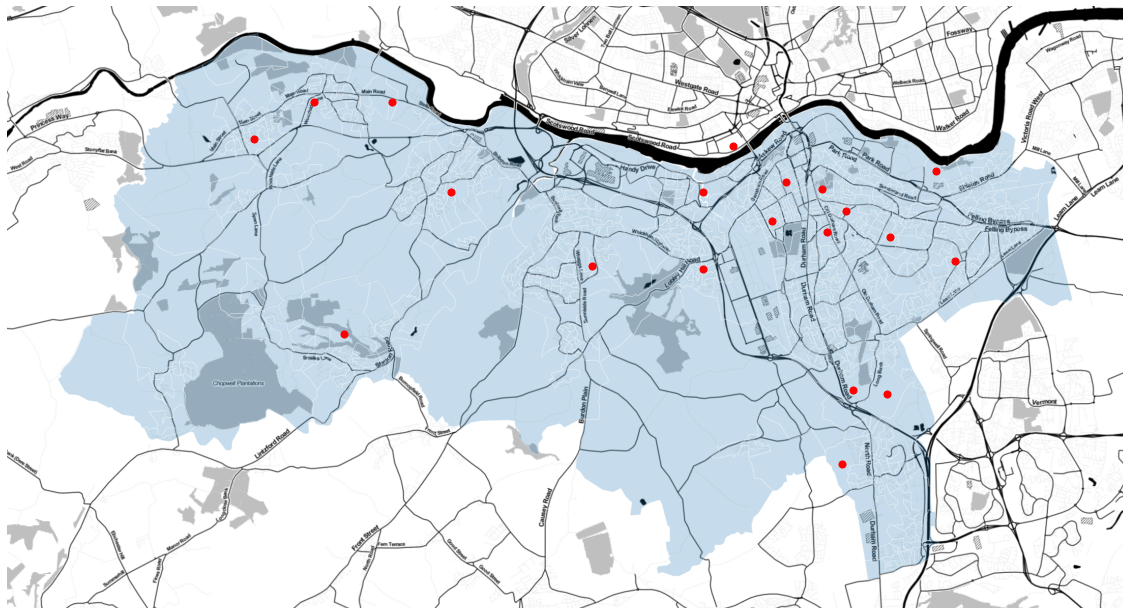

In [116]:
plot_sensors(points.x)